# Project 2
## Lending Club Regression
In the classification workbook we built a model to identify whether or not a loanee will default.  If a loanee does default, can we predict how much the investors will be out?  If there is a high probability that a loanee defaults, investors may still make a profit with a high enough interest rate.  

The purpose of this regression investigation is to see if we can predict the amount investors will profit / lose on loans which default.

In [55]:
# import our required libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
sns.set_context('poster')
sns.set(style='whitegrid', color_codes=True)

# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# models
#from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor

# scores
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix




To begin, we will import our pre-processed data.  We've identified several category columns and will ensure these are set with the appropriate datatype before moving forward. 

In [56]:
#define category columns
cat_cols = ['grade', 
            'sub_grade',
            'home_ownership',
            'verification_status',
            'loan_status',
            'purpose',
            'addr_state',
            'initial_list_status',
            'application_type',
            'hardship_flag'
           ]

# import data
df_raw = pd.read_csv('../data/processed/LCData_processed.csv', index_col=0)

# convert category columns
for c in cat_cols:
    df_raw[c] = pd.Categorical(df_raw[c])

We will create a subset of data focusing sepcifically on loans in a status of **default** and **charged off**.

In [57]:
df = df_raw[(df_raw.loan_status == 'Default') | (df_raw.loan_status == 'Charged Off')].copy()

## Profitable Loans
As mentioned above, we are trying to predict the amount that will be repaid. The repayment amount for loans is tracked by the **total_pymnt** column. The total includes repayment towards the loan principal amount, loan interest and collected late fees.

In order to see whether or not a default loan is profitable, we will create a new 'profit' column.  It will be calculated by taking the total payment minus the loan amount - providing us with a profit or loss for each loan. 

In [58]:
df['profit'] = df['total_pymnt'] - df['funded_amnt']

In [59]:
# have a look at the profit column
df[['loan_amnt','loan_status', 'total_pymnt', 'profit']].head(15)

,loan_amnt,loan_status,total_pymnt,profit
1,2500.0,Charged Off,1014.53,-1485.47
8,5600.0,Charged Off,647.50,-4952.50
9,5375.0,Charged Off,1484.59,-3890.41
12,9000.0,Charged Off,2277.32,-6722.68
14,10000.0,Charged Off,7471.99,-2528.01
21,21000.0,Charged Off,14034.60,-6965.40
24,6000.0,Charged Off,2055.85,-3944.15
26,15000.0,Charged Off,0.00,-15000.00
27,5000.0,Charged Off,1611.16,-3388.84
46,5000.0,Charged Off,5028.87,28.87


In [60]:
# Determine how many 'defaulted' loans are profitable
np.sum(df.profit > 0) / len(df)

0.048487748055081749

In [61]:
for g, d in df.groupby('grade'):
    profit_per = np.sum((df.grade==g) & (df.profit > 0)) / np.sum(df.grade==g)
    print('Grade {0}: {1:.3f}'.format(g, profit_per))

Grade A: 0.042
Grade B: 0.046
Grade C: 0.043
Grade D: 0.052
Grade E: 0.053
Grade F: 0.061
Grade G: 0.051


In [62]:
# check out the statistics 
df.profit.describe()

count    48074.000000
mean     -8444.679892
std       7005.590067
min     -39019.370000
25%     -12244.697500
50%      -6916.955000
75%      -3231.635000
max      20836.729788
Name: profit, dtype: float64

We find that about 5% of defaulted loans are actually profitable.  Loans for grade F appear to be the most profitable, followed by grades D, E and G respectively.  

## Linear Regression - Feature Engineered Columns
We have several features that relate directly to the status of a loan. These features need to be removed from our dataset prior to building our model.

Features will be removed from the dataset if they...
* are related to a lending club defined status (e.g. grade, sub_grade, loan_status)
* are related to the health status of a loan (e.g. current payments, interest collected, late fees etc) 

The features to be removed are as follows:

In [63]:
drop_cols = ['funded_amnt_inv',
             'total_pymnt',
             'total_pymnt_inv',
             'total_rec_int',
             'total_rec_late_fee',
             'total_rec_prncp',
             'out_prncp',
             'out_prncp_inv',
             'last_pymnt_amnt',
             'grade',
             'is_bad',
            'sub_grade',
            'loan_status']

df.drop(drop_cols, axis=1, inplace=True)

As we did in the classification workbook - let's first take a look at building a regression model using only the feature engineered columns from our EDA.  We are going to perform a basic linear regression first.

The steps are as follows
* Select feature engineered columns
* Create a model
* View accuracy score

In [64]:
feat_eng_cols = ['low_deliquent_job', 'credit_line_length_mnths', 'inq_last_6mths_cat', 
                 'pub_rec_cat', 'fully_funded', 'issue_d_month', 'issue_d_year', 'profit']

df_fe = df[feat_eng_cols].copy()

In [65]:
# create our X and y datasets
X = pd.get_dummies(df_fe.drop('profit', axis=1))
y = df_fe.profit

# split our data
X_train_fe, X_test_fe, y_train_fe, y_test_fe = train_test_split(X, y, test_size=0.25, random_state=42)


In [66]:
# create a pipeline for linear regression
pipe_fe = Pipeline([('scaler', StandardScaler()),
                 ('clf', LinearRegression())
                ])

# fit our data
pipe_fe.fit(X_train_fe, y_train_fe)

# predict the results
y_pred_fe = pipe_fe.predict(X_train_fe)

print('Training results')
print('score: {}'.format(pipe_fe.score(X_train_fe, y_train_fe)))
print('rmse: {}'.format(np.sqrt(mean_squared_error(y_train_fe, y_pred_fe))))

Training results
score: 0.15432797364400408
rmse: 6449.658277256654


In [67]:
# predict the results
y_pred_fe_test = pipe_fe.predict(X_test_fe)

print('Training results')
print('score: {}'.format(pipe_fe.score(X_test_fe, y_test_fe)))
print('rmse: {}'.format(np.sqrt(mean_squared_error(y_test_fe, y_pred_fe_test))))

Training results
score: 0.1428661555697689
rmse: 6463.541408175447


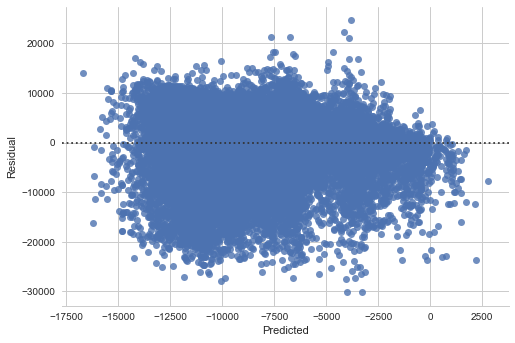

In [14]:
# Let's have a look at the residuals
sns.residplot(y_pred_fe, y_train_fe - y_pred_fe)
sns.despine(left=True)
plt.xlabel('Predicted')
plt.ylabel('Residual')

plt.show()

Our score is awful.  We have an accuracy score of 15%, with an RMSE of  ~$6460, we cannot accurately predict the profit/loss of a loan using only our feature engineered columns.  

The residual plot appears to be distributed randomly and we do not have any evidence of heteroscedasticity.

## Linear Regression - All Columns
We did not receive the greatest results when only usng our feature engineered columns  Let's use the same steps as above and see if we can imporve linear regression by using all data columns. 

In [68]:
# create our X and y datasets
X = pd.get_dummies(df.drop('profit', axis=1))
y = df.profit

# split our data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [69]:
# create a pipeline for linear regression
pipe = Pipeline([('scaler', StandardScaler()),
                 ('clf', LinearRegression())
                ])

# fit our data
pipe.fit(X_train, y_train)

# predict the results
y_pred = pipe.predict(X_train)

print('Training results')
print('score: {}'.format(pipe.score(X_train, y_train)))
print('rmse: {}'.format(np.sqrt(mean_squared_error(y_train, y_pred))))

Training results
score: 0.6823233462599047
rmse: 3953.0141799072335


In [71]:
# predict the test results
y_pred_test = pipe.predict(X_test)

print('Training results')
print('score: {}'.format(pipe.score(X_test, y_test)))
print('rmse: {}'.format(np.sqrt(mean_squared_error(y_test, y_pred_test))))

Training results
score: -2.9653384863145336e+16
rmse: 1202218344767.5295


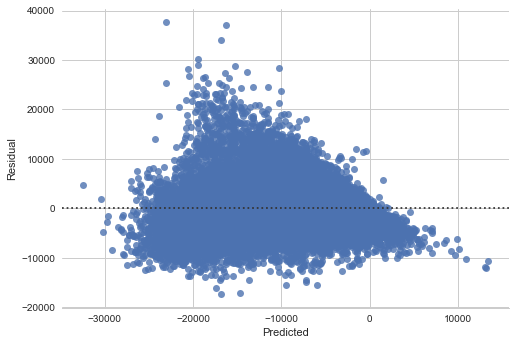

In [73]:
# Let's have a look at the residuals
sns.residplot(y_pred, y_train - y_pred)
sns.despine(left=True)

plt.xlabel('Predicted')
plt.ylabel('Residual')

plt.savefig('../reports/figures/reg_lr_af_results.png')

plt.show()

We have achieved a much better result in our linear regression when looking at our training data.  However upon applying our testing dataset, we find that our model is unable to make predictions outside of our training data.  The RMSE of our testing dataset is over 1.2 x 10^12.  We also see that the residual plot displays heteroscedasticity.

## Linear Regression - Feature Selection
We've seen heteroscedasticity in our prior model, which has poor results with our testing dataset.  In order to remove this heteroscedasticity, we will look at feature selection to eliminate collinearity . 

We will perform feature selection by hand, picking features which are correlated to our target variable (at least .2 pearson correlation).  

In [74]:
# create a function to calcluate Pearson correlation coefficient
def corr_func(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate('pearsonr = {}'.format(round(r, 3)), xy=(.1, .8), xycoords=ax.transAxes)

# create a function for creating a sns pairgrid
def create_pairgrid(columns):
    a = sns.PairGrid(df[columns], diag_sharey=False, size=3.9)
    a.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
    a.map_lower(corr_func)
    a.map_diag(sns.kdeplot, lw=2)
    a.map_upper(plt.scatter, alpha=.4)
    
    plt.savefig('../reports/figures/reg_lr_af_corr.png')

    plt.show()

//anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


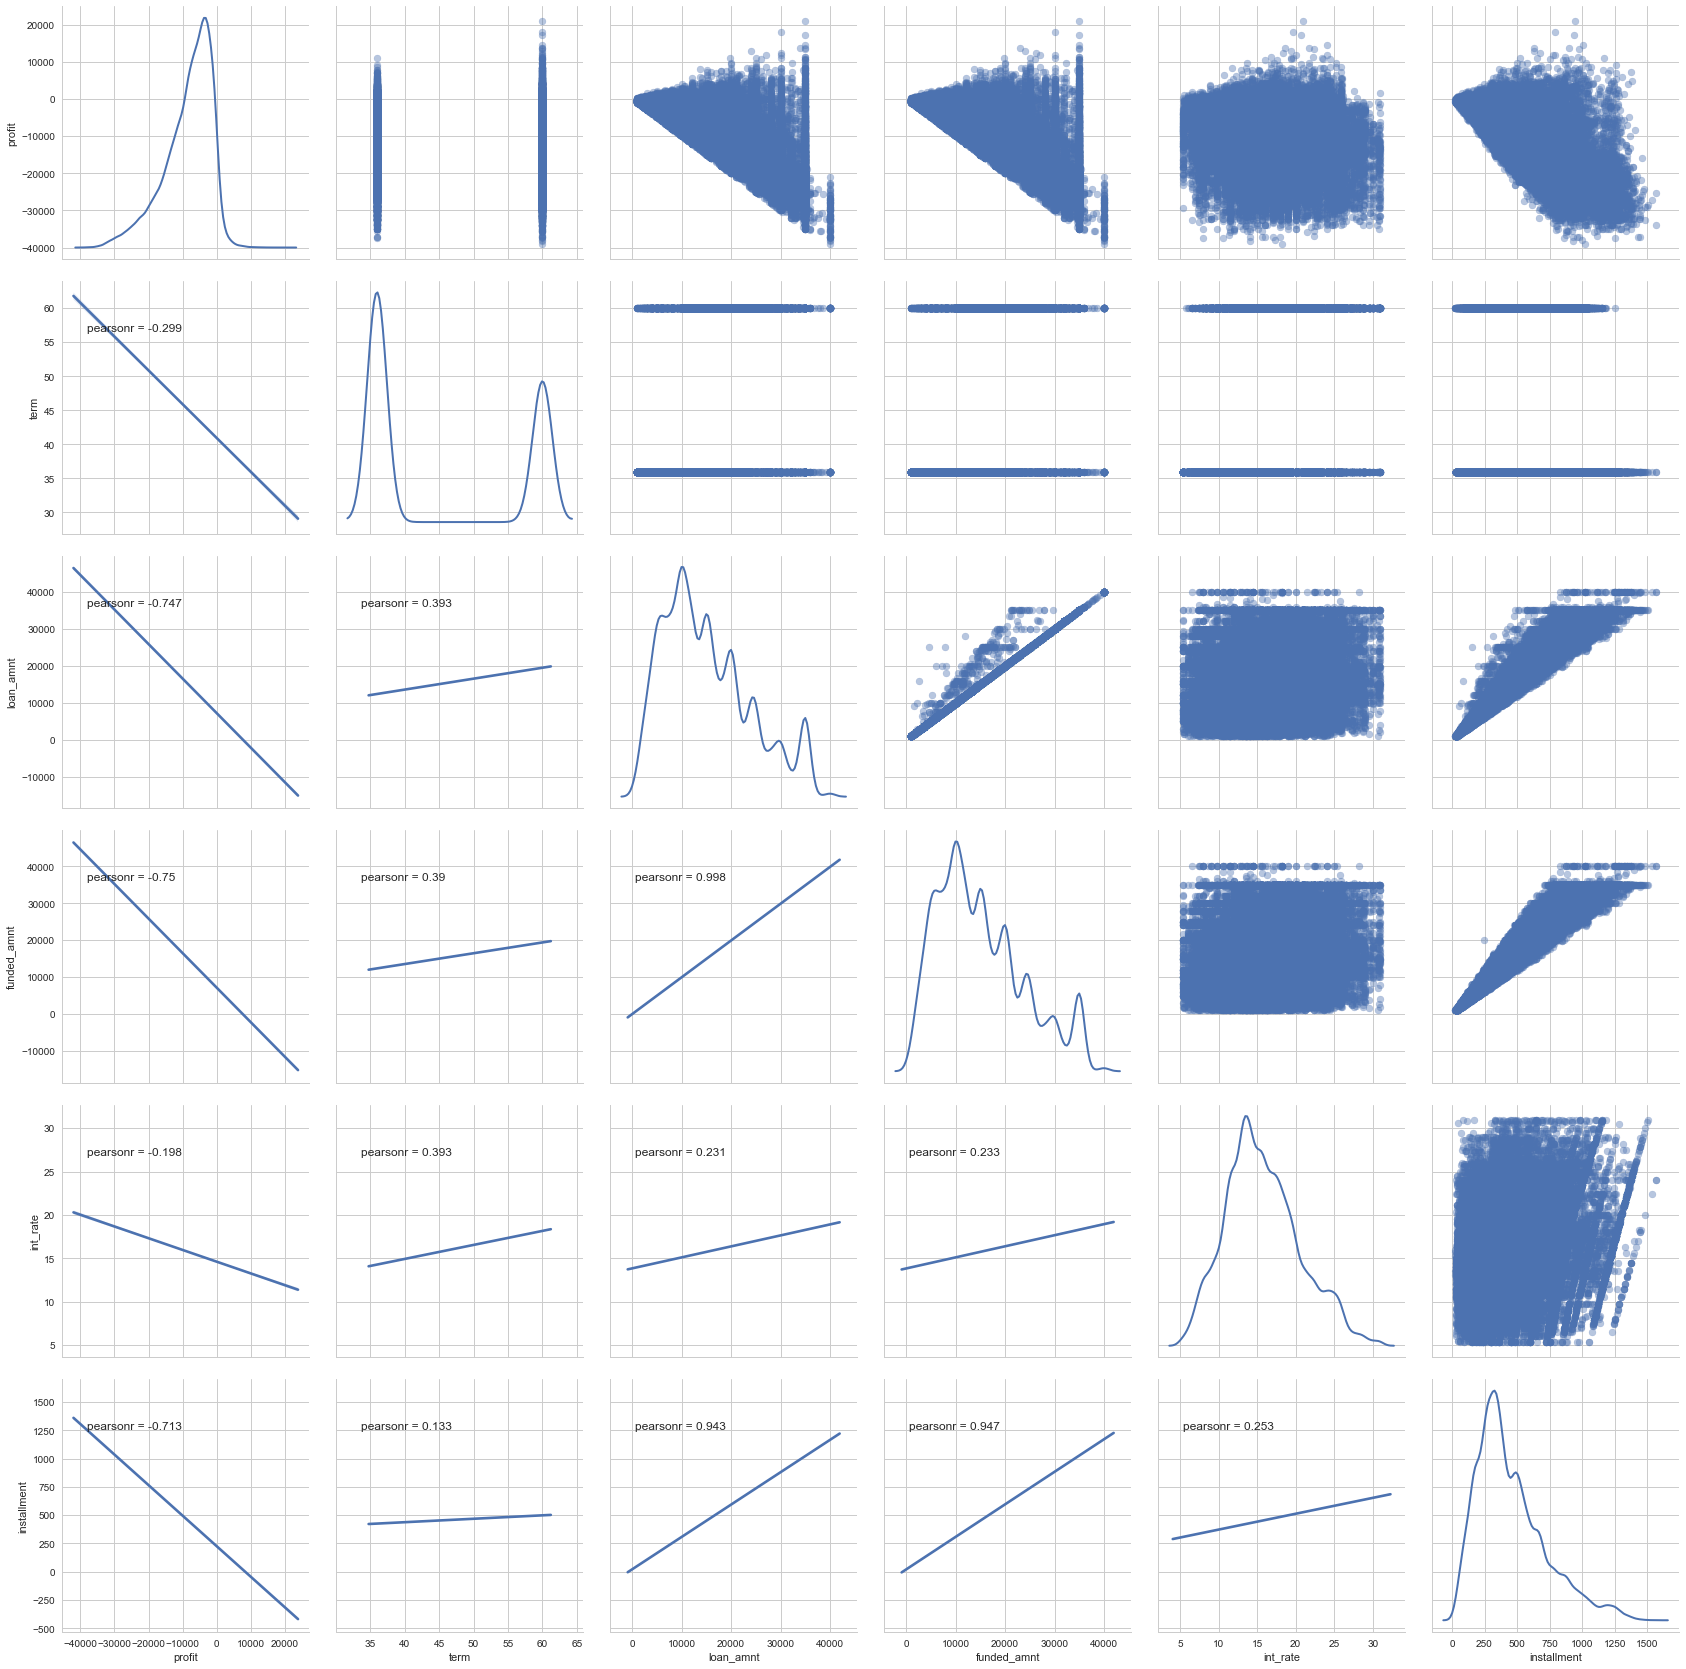

In [75]:
create_pairgrid(['profit', 'term', 'loan_amnt', 'funded_amnt', 'int_rate', 'installment'])

In [20]:
#create_pairgrid(['profit', 'emp_length', 'annual_inc', 'dti', 'delinq_2yrs','open_acc'])

In [21]:
#create_pairgrid(['profit', 'revol_bal','revol_util', 'total_acc', 'recoveries', 'collection_recovery_fee'])

In [22]:
#create_pairgrid(['profit', 'collections_12_mths_ex_med', 'acc_now_delinq',
#                 'tot_coll_amt','tot_cur_bal','total_rev_hi_lim'])

In [23]:
#create_pairgrid(['profit', 'acc_open_past_24mths', 'avg_cur_bal', 'chargeoff_within_12_mths', 
#                 'delinq_amnt', 'mo_sin_old_rev_tl_op' ])

In [24]:
#create_pairgrid(['profit', 'mort_acc', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 
#                 'num_actv_rev_tl', 'num_bc_sats'])

In [25]:
#create_pairgrid(['profit', 'mo_sin_rcnt_rev_tl_op','mo_sin_rcnt_tl',
#                 'mort_acc','num_accts_ever_120_pd','num_actv_bc_tl'])

In [26]:
#create_pairgrid(['profit', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 
#                 'num_rev_tl_bal_gt_0', 'num_sats'])

In [27]:
#create_pairgrid(['profit', 'num_actv_rev_tl','num_bc_sats',
#                 'num_bc_tl','num_il_tl','num_op_rev_tl'])

In [28]:
#create_pairgrid(['profit', 'num_rev_accts','num_rev_tl_bal_gt_0',
#                 'num_sats','num_tl_30dpd','num_tl_90g_dpd_24m'])

In [29]:
#create_pairgrid(['profit', 'num_tl_op_past_12m','pub_rec_bankruptcies',
#                 'tax_liens','tot_hi_cred_lim','total_bal_ex_mort'])

In [30]:
#create_pairgrid(['profit', 'total_bc_limit','total_il_high_credit_limit',
#                 'low_deliquent_job','credit_line_length_mnths','inq_last_6mths_cat'])

In [31]:
#create_pairgrid(['profit', 'pub_rec_cat','fully_funded',
#                 'issue_d_month','issue_d_year'])

In [108]:
non_corr_cols = [
    'emp_length', 'dti', 'delinq_2yrs', 'open_acc', 'revol_util', 'total_acc', 'recoveries', 'collection_recovery_fee',
    'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt', 'acc_open_past_24mths', 'avg_cur_bal',
    'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_rev_tl_op','mort_acc', 'num_accts_ever_120_pd', 
    'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'mo_sin_rcnt_rev_tl_op','mo_sin_rcnt_tl',
    'mort_acc','num_accts_ever_120_pd','num_actv_bc_tl', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts',
    'num_rev_tl_bal_gt_0', 'num_sats', 'num_actv_rev_tl','num_bc_sats', 'num_bc_tl','num_il_tl','num_op_rev_tl',
    'num_rev_accts','num_rev_tl_bal_gt_0', 'num_sats','num_tl_30dpd','num_tl_90g_dpd_24m','num_tl_op_past_12m',
    'pub_rec_bankruptcies', 'tax_liens','low_deliquent_job','credit_line_length_mnths','inq_last_6mths_cat',
    'pub_rec_cat', 'fully_funded', 'issue_d_month'
]

# Let's drop columns that we are not interested in
df_sub = df.drop(non_corr_cols, axis=1)

In [109]:
df_sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48074 entries, 1 to 59972
Data columns (total 22 columns):
loan_amnt                     48074 non-null float64
funded_amnt                   48074 non-null float64
term                          48074 non-null int64
int_rate                      48074 non-null float64
installment                   48074 non-null float64
home_ownership                48074 non-null category
annual_inc                    48074 non-null float64
verification_status           48074 non-null category
purpose                       48074 non-null category
addr_state                    48074 non-null category
revol_bal                     48074 non-null float64
initial_list_status           48074 non-null category
application_type              48074 non-null category
tot_cur_bal                   48074 non-null float64
total_rev_hi_lim              48074 non-null float64
tot_hi_cred_lim               48074 non-null float64
total_bal_ex_mort             48074 non

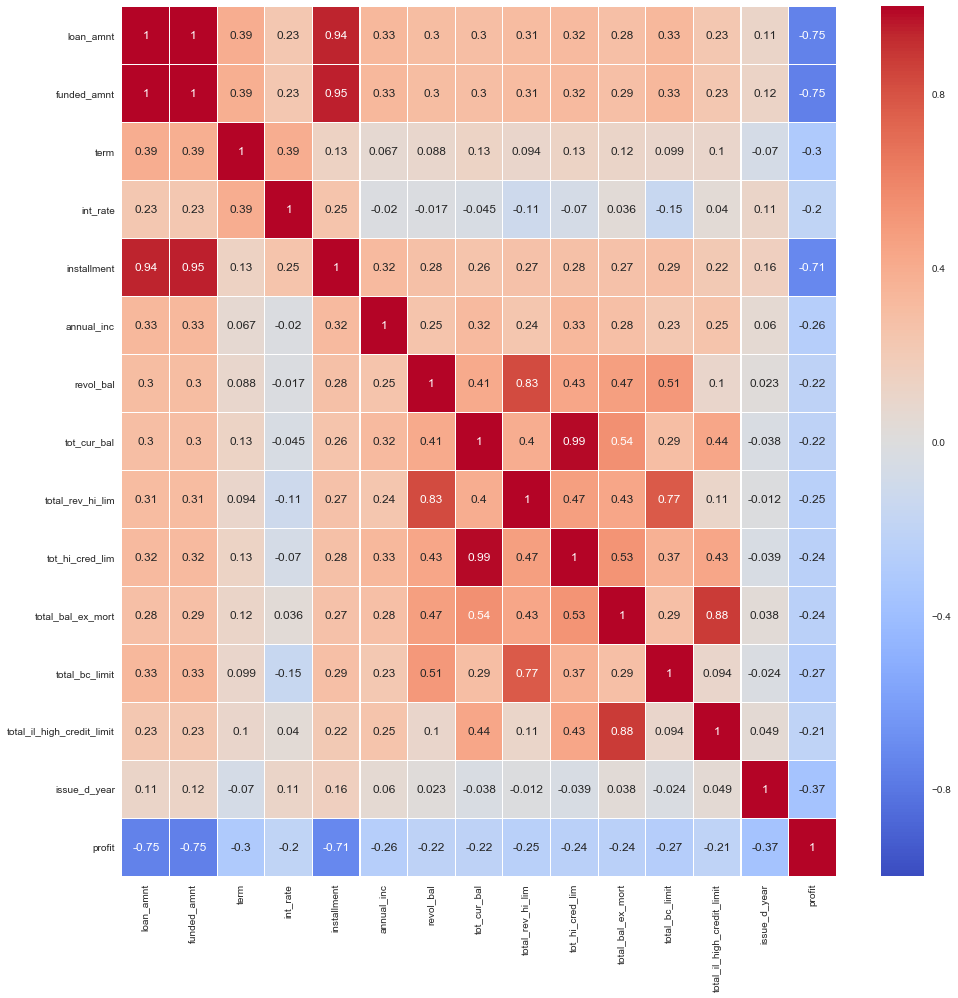

In [110]:
# let's see if our remaining columns are correlated
plt.figure(figsize=(16,16))
sns.heatmap(df_sub.corr(), cmap='coolwarm', annot=True, linewidth=.1)

plt.savefig('../reports/figures/reg_lr_af_corr_matrix.png')
    
plt.show()

We have some highly correlated features here.  For now - let's remove these highly correlated features and build a model.  Specifically:
* funded_amnt
* installment
* tot_cur_bal
* total_rev_hi_lim
* tot_hi_cred_lim
* total_il_high_credit_limit

In [111]:
df_sub = df_sub.drop(['funded_amnt', 'installment', 'tot_cur_bal', 'total_rev_hi_lim', 'total_il_high_credit_limit', 'tot_hi_cred_lim'],
                   axis=1)

In [112]:
# create our X and y datasets
X = pd.get_dummies(df_sub.drop('profit', axis=1))
y = df_sub.profit

# split our data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [113]:
# create a pipeline for linear regression
pipe = Pipeline([('scaler', StandardScaler()),
                 ('clf', LinearRegression())
                ])

# fit our data
pipe.fit(X_train, y_train)

# predict the results
y_pred = pipe.predict(X_train)

print('Training results')
print('score: {}'.format(pipe.score(X_train, y_train)))
print('rmse: {}'.format(np.sqrt(mean_squared_error(y_train, y_pred))))

Training results
score: 0.6531752672674855
rmse: 4130.387071284386


In [114]:
# predict the results for test
y_pred_test = pipe.predict(X_test)

print('Training results')
print('score: {}'.format(pipe.score(X_test, y_test)))
print('rmse: {}'.format(np.sqrt(mean_squared_error(y_test, y_pred_test))))

Training results
score: -1.374367234047566e+21
rmse: 258819867103130.6


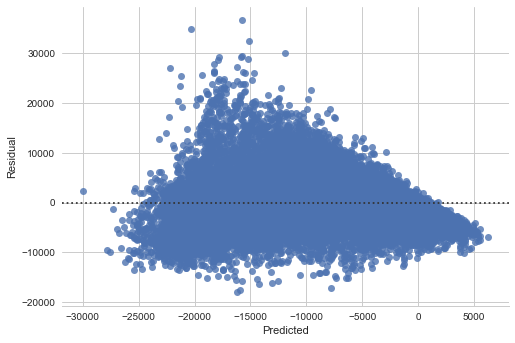

In [115]:
# Let's have a look at the residuals
sns.residplot(y_pred, y_train - y_pred)
sns.despine(left=True)

plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.show()

We've managed to keep a similarly awful score with our test dataset by reducing the number of features used.  Again, our residual plot also appears to have heteroscedasticity.  Let's try a different model to see if we can reduce the rmse value. 

## Decision Tree Regressor - Feature Selection

In [116]:
# create our X and y datasets
X = pd.get_dummies(df_sub.drop('profit', axis=1))
y = df_sub.profit

# split our data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [120]:
# create a pipeline for linear regression
pipe = Pipeline([('scaler', StandardScaler()),
                 ('clf', DecisionTreeRegressor())
                ])

# fit our data
pipe.fit(X_train, y_train)

# predict the results
y_pred = pipe.predict(X_train)

print('Training results')
print('score: {}'.format(pipe.score(X_train, y_train)))
print('rmse: {}'.format(np.sqrt(mean_squared_error(y_train, y_pred))))

Training results
score: 1.0
rmse: 0.0


Our training results appear to be great - but how does this fair with our test dataset?

In [121]:
#predict the results
y_pred_test = pipe.predict(X_test)

print('Testing results')
print('score: {}'.format(pipe.score(X_test, y_test)))
print('rmse: {}'.format(np.sqrt(mean_squared_error(y_test, y_pred_test))))

Testing results
score: 0.49900192787165887
rmse: 4941.561911114772


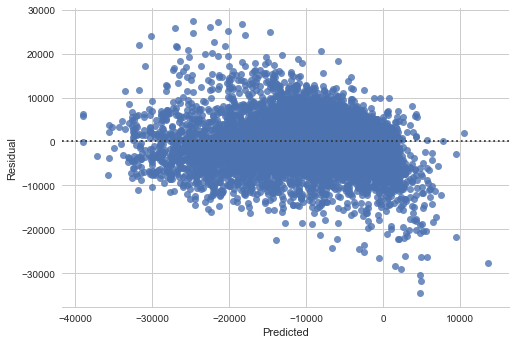

In [125]:
# Let's have a look at the residuals for our test
sns.residplot(y_pred_test, y_test - y_pred_test)
sns.despine(left=True)

#set labels
plt.xlabel('Predicted')
plt.ylabel('Residual')

plt.savefig('../reports/figures/reg_dt_fs_residuals.png')

plt.show()

We had really great training results, but  we find that we have a large RMSE score when validating the model using the test dataset.  This means we do not have great prediction results, however it is better than linear regression.  We also notice that the heteroscedasticity seen in linear regression has been decreased. 

Let's try using a random forest to increase accuracy and predictions.

## Random Forest Regressor - Feature Selection

In [132]:
# create our X and y datasets
X = pd.get_dummies(df_sub.drop('profit', axis=1))
y = df_sub.profit

# split our data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [133]:
from sklearn.ensemble import RandomForestRegressor

# create a pipeline for linear regression
pipe = Pipeline([('scaler', StandardScaler()),
                 ('clf', RandomForestRegressor())
                ])

# fit our data
pipe.fit(X_train, y_train)

# predict the results
y_pred = pipe.predict(X_train)

print('Training results')
print('score: {}'.format(pipe.score(X_train, y_train)))
print('rmse: {}'.format(np.sqrt(mean_squared_error(y_train, y_pred))))

Training results
score: 0.948737328191105
rmse: 1587.9482369213995


In [44]:
#predict the results
y_pred = pipe.predict(X_test)

print('Testing results')
print('score: {}'.format(pipe.score(X_test, y_test)))
print('rmse: {}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))

Testing results
score: 0.7030462463884828
rmse: 3804.43898347091


The random forest appears to have a closed the gap between our training & testing dataset.  The RMSE is still large.  Let's see if we can tweak the parameters to improve our results. 

We will begin by perfoming individual tuning of parameters in order to have an idea of the ranges we should focus.

In [45]:
# plot results allows us to test a parameter range and plot the results
def plot_results(clf, param_name, param_values, plot_index):
    """
    Description
    -----------
        Allows us to test a parameter range and plot the results
        
    Parameters
    -----------
    clf: The classifier to be used for tuning
    
    param_name: name of the parameter to be tuned
    
    param_values: an array of values to be tested for the given parameter
    
    plot_index: identifies the index of the given subplot.  For this given setup, we 
        assume that we are using a 3 cols x 2 row setup

    
    """
    # create the grid search
    grid_search = GridSearchCV(clf, 
                               param_grid = {param_name:param_values},
                               return_train_score=True)
    
    # fit the estimator
    grid_search.fit(X_train, y_train)
    
    # create a dictionary to store the scores
    scores_dic = {}
    
    # loop through the parameter values tested
    for i, param_dic in enumerate(grid_search.cv_results_['params']):
        
        # Store the parameter tested with the related mean training score
        scores_dic[param_dic[param_name]] = grid_search.cv_results_['mean_train_score'][i]
    
    # create a dataframe from the parameter scores
    scores_df = pd.DataFrame.from_dict(scores_dic, orient='index')
    scores_df.reset_index(inplace=True)
    scores_df.columns = ['param', 'score']
    
    # plot the result
    plt.subplot(3, 2, plot_index)
    
    # if we are plotting max_features, we need to adjust the x values, as they are not
    # numeric.  Otherwise, we can just use the parameter values
    if param_name == 'max_features':
        plt.plot(np.arange(len(scores_df)), scores_df.score)
        plt.xticks(np.arange(len(scores_df)), scores_df.param.values)
    else:
        plt.plot(scores_df.param, scores_df.score)

    # add a title
    plt.title(param_name)


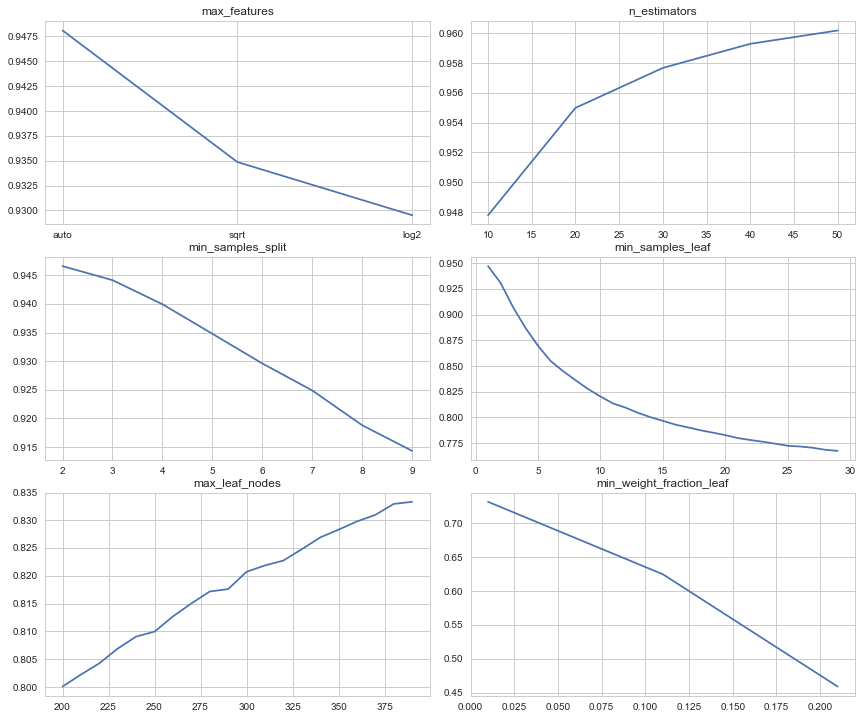

In [46]:
# Create the param_grid for testing
param_grid = {'max_features':['auto', 'sqrt', 'log2'],
              'n_estimators':[10, 20, 30, 40, 50],
              'min_samples_split': np.arange(2,10,1),
              'min_samples_leaf': np.arange(1,30,1),
              'max_leaf_nodes': np.arange(200,400,10),
              'min_weight_fraction_leaf': np.arange(0.01,0.3, 0.1)
             }

# create figure area
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))
fig.tight_layout()

# loop through each parameter & value range, plotting the accuracy results
for i, (k, v) in enumerate(param_grid.items()):

    # call to display graph
    plot_results(RandomForestRegressor(n_jobs=-1), k, v, i+1)

plt.show()

Based on the above results, we now have a better idea of the range of values to be used for each parameter. In our next steps below, we narrow our range for each parameter and pass the parameter grid into a GridSearchCV to find the optimal parameters for our random forest estimator. 

n_estimators
* I'll be choosing a value between 20 - 40.  Although we have a higher score with a greater number of estimators, we are only achieving a 0.004 to 0.006 increase when doubling the number of estimators. 

min_samples_split
* Select values between 2 and 5

min_samples_leaf
* Select a value between 2 and 4

max_leaf_nodes
* we achieve a higher score with a higher number of leaf nodes - but we are also creating a much more complex model.  We will aim for a value between 400 and 500 and see what we get. 

min_weight_fraction_leaf
* we will select a value between 0.001 and 0.003

In [47]:
# define our parameter grid
param_grid = {'clf__n_estimators':[20, 30, 40],
              'clf__min_samples_split': np.arange(2,5,1),
              'clf__min_samples_leaf': np.arange(2,5,1),
              'clf__max_leaf_nodes': np.arange(300,500,10),
              'clf__min_weight_fraction_leaf': np.arange(0.01,0.04, 0.01)
             }


In [48]:
from sklearn.model_selection import RandomizedSearchCV

# create a pipeline for linear regression
pipe = Pipeline([('scaler', StandardScaler()),
                 ('clf', RandomForestRegressor(n_jobs=-1,random_state=42))
                ])

grid_search = RandomizedSearchCV(pipe, param_grid, cv=5)

# fit our data
grid_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_spl...timators=10, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False))]),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'clf__n_estimators': [20, 30, 40], 'clf__min_samples_split': array([2, 3, 4]), 'clf__min_samples_leaf': array([2, 3, 4]), 'clf__max_leaf_nodes': array([300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420,
       430, 440, 450, 460, 470, 480, 490]), 'clf__min_weight_fraction_leaf': array([ 0.01,  0.02,  0.03])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=

In [49]:
grid_search.best_estimator_

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=320,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=4,
           min_weight_fraction_leaf=0.01, n_estimators=40, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False))])

With the optimal parameters identified, we can create the final model

In [140]:
# create a pipeline for linear regression
pipe = Pipeline([('scaler', StandardScaler()),
                 ('clf', RandomForestRegressor(max_depth=None,
           max_features='auto', max_leaf_nodes=320,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=4,
           min_weight_fraction_leaf=0.01, n_estimators=40, n_jobs=-1,
           oob_score=False, random_state=42))
                ])

# fit our data
pipe.fit(X_train, y_train)

# predict the results
y_pred = pipe.predict(X_train)

print('Training results')
print('score: {}'.format(pipe.score(X_train, y_train)))
print('rmse: {}'.format(np.sqrt(mean_squared_error(y_train, y_pred))))

Training results
score: 0.7307229514838347
rmse: 3639.446936675929


In [141]:
#predict the results for test
y_pred_test = pipe.predict(X_test)

print('Testing results')
print('score: {}'.format(pipe.score(X_test, y_test)))
print('rmse: {}'.format(np.sqrt(mean_squared_error(y_test, y_pred_test))))

Testing results
score: 0.7267594078651619
rmse: 3649.3777715881956


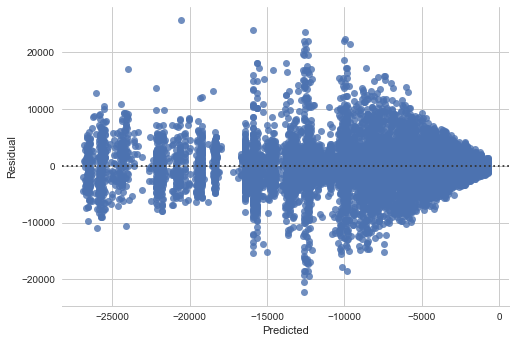

In [142]:
# Let's have a look at the residuals for our test
sns.residplot(y_pred_test, y_test - y_pred_test)
sns.despine(left=True)

#set labels
plt.xlabel('Predicted')
plt.ylabel('Residual')

plt.savefig('../reports/figures/reg_rf_fs_residuals.png')

plt.show()

Using hyperparameter tuning we've been able to improve the performance of our model, reducing the RMSE down to ~3650 on our test dataset. This still appears to be a high RMSE and we still have heteroscedasticity within the dataset. 

## Random Forest Regressor - All Features
Out of curiosity - how well does our random forest regressor work when all features are used? 


In [129]:
# create our X and y datasets
X = pd.get_dummies(df.drop('profit', axis=1))
y = df.profit

# split our data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [130]:
# create a pipeline for linear regression
pipe = Pipeline([('scaler', StandardScaler()),
                 ('clf', RandomForestRegressor(max_leaf_nodes=400,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.01, n_estimators=40, n_jobs=-1))
                ])

# fit our data
pipe.fit(X_train, y_train)

# predict the results
y_pred = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

print('Training results')
print('score: {}'.format(pipe.score(X_train, y_train)))
print('rmse: {}'.format(np.sqrt(mean_squared_error(y_train, y_pred))))

print()
print('Testing results')
print('score: {}'.format(pipe.score(X_test, y_test)))
print('rmse: {}'.format(np.sqrt(mean_squared_error(y_test, y_pred_test))))

Training results
score: 0.7670061997188445
rmse: 3385.38374835849

Testing results
score: 0.7614432988615567
rmse: 3409.9029906397504


Using all features, we find that the RMSE performs slightly better than our model using our hand picked feature selection.  Although better, we are still at an RMSE of $3400.  This is still a considerably high RMSE, and does not appear to be a worthy model for our purpose. 

## Conclusion
Based on the above findings, we've found that only ~5% of default loans are actually profitable.  These loans tend to be within the Grades of D, E, & F. 

We observed multiple correlated features within the dataset provided.  Subsetting the dataset to remove collinearity, we were only able to achieve an RMSE of ~$3650 using a Random Forest Regressor with feature selection. 

Even if we are able to correctly identify a loanee as a potential default, we can only predict the payback with an accuracy of +/- $3650.  This does not provide great confidence.

The reason behind the inaccurate prediction is most likely due to the high variance in repayment.  There are many factors that go into the prediction, many which lie outside of the dataset provided. For example, a loanee could lose their source of income, or environmental impacts such as hurricanes & floods could increase financial burdens.

This was a good exercise in creation of a regression model, but ultimately did not provide a model that could be used in predicting loan repayment. 